In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install timm

In [3]:
import sys
sys.path.append('drive/MyDrive/ai/final/petfinder-pawpularity-score')
### <디렉토리 설정하는 곳> (검색용) ################################################################################################
### 지금 위의 코드는
### 이 코드파일(ai_final_loss_plot.ipynb)과 함께 다른 데이터셋 관련파일들(test, train, sample_submission.csv, test.csv, train.csv)을 
### 구글드라이브 안의 /ai/final/petfinder-pawpularity-score 디렉토리에 넣어줘야, 코드가 돌아가도록 되어있다.
###
### 위에서 말한 코드파일과 데이터셋 관련 파일들의 위치를 바꾸고 싶으면, 
### 위의 sys.path.append() 안의 인자를 'drive/MyDrive/(구글 드라이브 내의 디렉토리 주소)' 로 바꿔주면 된다.
####################################################################################################################################

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

import cv2
from os import path
from PIL import Image
import torch.utils.data as data
from torchvision import models, transforms
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import h5py
import timm
import shutil

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

In [5]:
class args:
### <배치크기, 에폭수 설정하는 곳 (검색용)> ######################
### 지금은 batch_size 값 32, 에폭수 10으로 되어있다. 
##################################################################

    seed = 22
    batch_size = 64
    epochs = 5
    image_size = 384  # scale shorter end of image to this size and centre crop
    central_fraction = 0.875  # only take this much of the centre when scaling and centre cropping
    load_img = False # whether load img or not
    workers = 2
    feature_extract = True

def seed_torch(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print("seed: ", seed)

seed_torch(args.seed)

seed:  22


In [6]:
def makedirs(path): 
  if os.path.exists(path):
    shutil.rmtree(path)
  try: 
    os.makedirs(path) 
  except OSError: 
    if not os.path.isdir(path): 
      raise

In [7]:
dir_path = 'drive/MyDrive/ai/final/petfinder-pawpularity-score'
### <디렉토리 설정하는 곳> (검색용) ################################################################################################
### 지금 위의 코드는
### 이 코드파일(ai_final_loss_plot.ipynb)과 함께 다른 데이터셋 관련파일들(test, train, sample_submission.csv, test.csv, train.csv)을 
### 구글드라이브 안의 /ai/final/petfinder-pawpularity-score 디렉토리에 넣어줘야, 코드가 돌아가도록 되어있다.
###
### 위에서 말한 코드파일과 데이터셋 관련 파일들의 위치를 바꾸고 싶으면, 
### 위의 sys.path.append() 안의 인자를 'drive/MyDrive/(구글 드라이브 내의 디렉토리 주소)' 로 바꿔주면 된다.
####################################################################################################################################

cached_dir = path.join(dir_path, 'cached_data')
train_img_dir = path.join(dir_path, 'train')
test_img_dir = path.join(dir_path, 'test')
aug_img_dir = path.join(dir_path, 'train_aug')

df_train = pd.read_csv(path.join(dir_path, 'train.csv'))
df_test = pd.read_csv(path.join(dir_path, 'test.csv'))

train_img_paths = [path.join(train_img_dir, f"{img_id}.jpg") for img_id in df_train["Id"].values]
test_img_paths = [path.join(test_img_dir, f"{img_id}.jpg") for img_id in df_test["Id"].values]

# 경로에 파일 없으면 생성 있으면 지우고 재생성 
makedirs(aug_img_dir)

In [8]:
property_names = [col for col in df_train.columns if col not in ['Id','Pawpularity']]
property_names # 12 properties

# train metda data
train_meta_X = df_train[property_names]
train_Y = df_train['Pawpularity']

# test metda data
test_id = df_test['Id']
test_meta_X = df_test.drop('Id',axis=1)
test_meta_X.shape

(8, 12)

In [9]:
class PawpularDataset(data.Dataset):
    def __init__(self, image_data, meta_features, labels, img_paths, augmentations=None):
        super(PawpularDataset, self).__init__()
        self.load_img = False
        self.image_data = image_data
        self.meta_features = meta_features
        self.labels = labels
        self.augmentations = augmentations
        self.image_paths = img_paths
        if self.augmentations is not None:
            self.load_img = True


    def __getitem__(self, item):
        if self.load_img:
            image = cv2.imread(self.image_paths[item])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            augmented = self.augmentations(image=image)["image"]
            
            #augmentation 저장
            save_aug(augmented,item)

            image = np.transpose(augmented, (2, 0, 1)).astype(np.float32)
        else:
            image = self.image_data[item]

        meta = self.meta_features[item]
        label = self.labels[item]
        return image.astype('float32'), meta.astype('float32'), label

    def __len__(self):
        return len(self.labels)

def save_aug(image, item):
    global aug_img_dir
    """
    Function to Plot the Transformed Images
    """
    #print(label)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    path = aug_img_dir+ "/" +str(item)+".jpg" 
    # print(path)
    cv2.imwrite(path, image)
    #Unnormalize
    # plt.imshow(image)
    # plt.show()

def get_loader(split, features, meta_data, labels, img_paths=[], batch_size=args.batch_size, augmentations=None):
    """ Returns a data loader for the desired split """
    dataset = PawpularDataset(features, meta_data, labels, img_paths, augmentations)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True if split != 'test' else False,  # only shuffle the data in training
        pin_memory=True,
        num_workers=args.workers,
    )
    return loader

In [10]:
import albumentations

def get_augmentations(train=True):
    if train:
        return albumentations.Compose(
            [
                ## 크기조절
                albumentations.Resize(args.image_size, args.image_size, p=1),
                ## 좌우 반전
                albumentations.HorizontalFlip(p=0.5),
                ## 상하 반전
                ##albumentations.VerticalFlip(p=0.5),
                ## 회전
                albumentations.Rotate(limit=45, p=0.7),
            ]
        )
    else:
        return albumentations.Compose(
            [
                albumentations.Resize(args.image_size, args.image_size, p=1),
#                 albumentations.Normalize(
#                     mean=[0.485, 0.456, 0.406],
#                     std=[0.229, 0.224, 0.225],
#                     max_pixel_value=255.0,
#                     p=1.0,
#                 ),
            ]
        )

augmentations = get_augmentations(train=True)
trainval_loader = get_loader('trainval', None, train_meta_X.values, train_Y.values.astype('float32'), train_img_paths,augmentations=augmentations)

augmentations = get_augmentations(train=False)
test_loader = get_loader('test', None, test_meta_X.values, torch.zeros(len(test_img_paths)), test_img_paths, augmentations=augmentations)

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### <인공지능 모델 아키텍처 설정하는 곳> (검색용) ################################################################################################
### 아래에는 다음과 같은 모델 아키텍처를 정의하는 class 코드가 있음.
### 
### PretrainedCNN         - 이미 학습되어있는 "resnet" 모델을 불러오고, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### BaseCNN               - CNN 을 활용한 모델, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### BaseMLP               - MLP 를 활용한 모델, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### PretrainedTransformer - 이미 학습되어있는 다양한 모델들 중 하나를 불러오고, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
###
### 이 아래에 class 중에서 직접 수정해보면 좋은 것은, BaseCNN , BaseMLP class 부분임.
### BaseCNN 은 CNN 실습했을때처럼 수정하면 될 듯
### BaseMLP 는 MLP 실습했을때처럼 수정하면 될 듯
###
### 한편, PretrainedTransformer class 를 활용해도 좋음. 이미 학습되어있는 모델을 불러와서 코드를 돌려볼 수 있음. 자세한 내용은 아래 <모델 고르기> 부분에서 설명함.
####################################################################################################################################



class PretrainedCNN(nn.Module):
    def __init__(self, model_name='resnet', use_meta=False):
        super(PretrainedCNN, self).__init__()
        if model_name == 'resnet':
            self.model = models.resnet152(pretrained=True)
            set_parameter_requires_grad(self.model, feature_extracting=True)
            num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 128)
        self.drop = nn.Dropout(0.5)
        self.use_meta =use_meta
        if self.use_meta:
            self.fc = nn.Linear(128+12, 1)
        else:
            self.fc = nn.Linear(128, 1)
        

    def forward(self, img_data, meta=None, targets=None):
        x = self.model(img_data)
        if self.use_meta:
            x = torch.cat([x, meta], dim=1)
        x = self.fc(self.drop(x)) # [b, o]
        return x



class BaseCNN(nn.Module):
    def __init__(self, num_filters=[], use_meta=False):
        super(BaseCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, num_filters[0], kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(num_filters[0], num_filters[1], kernel_size = 4, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(num_filters[1], num_filters[2], kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(num_filters[2] ,num_filters[3], kernel_size = 8, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(num_filters[3], num_filters[4], kernel_size = 6, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(num_filters[4], num_filters[4], kernel_size = 6, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(12544, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,128)
        )
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        if self.use_meta:
            self.fc = nn.Linear(128+12, 1)
        else:
            self.fc = nn.Linear(128, 1)


    def forward(self, img_data, meta=None, targets=None):
        o = self.conv(self.drop(img_data)) # [b, 1, m]
        if self.use_meta:
            o = torch.cat([o, meta], dim=1)
        x = self.fc(self.drop(o)) # [b, o]
        return x


class BaseMLP(nn.Module):
    def __init__(self, use_meta=False, input_size=args.image_size):
        super(BaseMLP, self).__init__()
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        self.lin = nn.Sequential(
            nn.Linear(input_size*input_size, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(3),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(3),
            nn.Dropout(0.5),
            nn.Linear(512,128)
        )
        if self.use_meta:
            self.fc = nn.Linear((128*3)+12, 1)
        else:
            self.fc = nn.Linear(128*3, 1)


    def forward(self, img_data, meta=None, targets=None):
        b, c, img_size, _ = img_data.shape
        img_data = img_data.view(b, c, img_size*img_size)
        o = self.lin(self.drop(img_data)) # [b, 3, 128]
        o = o.view(b, -1)
        if self.use_meta:
            o = torch.cat([o, meta], dim=1)
        x = self.fc(self.drop(o)) # [b, o]
        return x


class PretrainedTransformer(nn.Module):
    def __init__(self, model_name='', use_meta=False, pretrained=True):
        super(PretrainedTransformer, self).__init__()
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        set_parameter_requires_grad(self.model, feature_extracting=True)
        num_features = self.model.num_features

        if self.use_meta:
            self.fc = nn.Linear(num_features+12, 1)
        else:
            self.fc = nn.Linear(num_features, 1)


    def forward(self, img_data, meta=None, targets=None):
        x = self.model(img_data)
        if self.use_meta:
            x = torch.cat([x, meta], dim=1)
        x = self.fc(self.drop(x)) # [b, o]
        return x




torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [12]:
import matplotlib.pyplot as plt ##5
test_loss_record = [] ##5
mse = nn.MSELoss()  ##


def train(model, optimizer, train_loader, val_loader, train=True, val=False, epoch=0, grad_clip=False):
    labels, preds = [], []
    if train:
        #mse = nn.MSELoss() -> 이건 밖으로 빼서 전역변수로 만들었음 ##
        train_loader = tqdm(train_loader, desc='{} E{:03d}'.format('train', epoch), ncols=0)
        model.train()
        for i, (img, meta_feature, label) in enumerate(train_loader):
            img = img.cuda().float()
            meta_feature = meta_feature.cuda()
            label = label.cuda()
            pred = model(img, meta_feature, label)

            # loss = criterion(pred , label.view(-1,1))
            loss = mse(pred, label.view(-1, 1))

            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

            num = 10
            if i % num == 0:
                rmse_loss = pow(loss.item() , 0.5)
                print("\tTrain Epoch:{} \tTrain Loss(RMSE): {:.6f}".format(epoch, rmse_loss)) ##
                test_loss_record.append(rmse_loss)
    
    if val:
        model.eval()
        val_loader = tqdm(val_loader, desc='{} E{:03d}'.format('val', epoch), ncols=0)
        for i, (img, meta_feature, label) in enumerate(val_loader):
            img = img.cuda().float()
            pred = model(img, meta_feature, None)

            labels.append(label.detach().cpu())
            preds.append(pred.detach().cpu())

        labels = torch.cat(labels, dim=0).numpy() # [num_seg]
        preds = torch.cat(preds, dim=0).numpy() # [num_seg]

    return labels, preds

In [13]:
### <학습된 모델 확인하기> (검색용) ######################
### 사용할 수 있는 이미 학습된 모델들을 아래 출력해줌
############################################################
timm.list_models()[:]

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n

In [14]:
import torch.optim as optim

name = 'tf_efficientnet_b0_ns'

### <모델 고르기> (검색용) ##########################################################################################################
### 학습에 사용할 인공지능 모델을 골라준다.
### 아래 주석을 해제하여 사용
### 
### PretrainedTransformer 사용하는 방법
### 1. 아래 "model = PretrainedTransformer.." 가 있는 줄의 주석을 해제한다.
### 2. 아까 위에서 <학습된 모델 확인하기>에서 출력된 모델 중 하나를 고른다.
### 3. 아래 (학습된 모델 이름) 에 넣어준다.
#####################################################################################################################################
#model = PretrainedCNN(use_meta = True)                                          ### PretrainedCNN(resnet모델) 을 사용하는 경우
#model = BaseCNN(num_filters=[4,5,6,7,8], use_meta = True)                                                ### BaseCNN 을 사용하는 경우
#model = BaseMLP(use_meta = True)                                                ### BaseMLP 를 사용하는 경우
model = PretrainedTransformer(model_name='seresnet50', use_meta = True) ### PretrainedTransformer 을 사용하는 경우 


params_to_update = model.parameters()
print("Params to learn:")
if args.feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

### <optimizer 설정하는 곳> (검색용) ########################################################################
### 지금은 optim.Adam 으로 설정되어있음. optim.Adam 대신 다른 optimizer 알고리즘으로 바꿀수 있다.
###
### 다른 optimizer들 : optim.Adadelta , optim.Adagrad, optim.AdamW 등등
### 다른 optimizer로 바꾸려면, 해당 optimizer 알고리즘에 필요한 인자들을 알맞게 넣어줘야 한다. 
### 인자를 넣는 형식 등 자세한 사용법은 https://pytorch.org/docs/stable/optim.html 에 가서 
### Algorithms 부분 밑에 알고리즘을 클릭해서 들어가면 알 수 있음.
####################################################################################################
learning_rate = 1e-3
optimizer = optim.Adam(params_to_update, lr=learning_rate, amsgrad=False)
model = nn.DataParallel(model).cuda()

Params to learn:
	 fc.weight
	 fc.bias


In [15]:
##5  추가한 코드셀
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    #correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += mse(output, label).item()
    
    test_loss /= (len(test_loader.dataset) / args.batch_size)

    return test_loss

In [16]:
# # Train & val the model
best_score = 0
epochs = args.epochs



for epoch in range(epochs):
    labels, pred = train(model, optimizer, trainval_loader, None, train=True, val=False, epoch=epoch, grad_clip=True)

    torch.save({"model": model.state_dict()}, "efficient_model.pth")

train E000:   1% 1/155 [00:16<41:44, 16.26s/it]

	Train Epoch:0 	Train Loss(RMSE): 43.950927


train E000:   7% 11/155 [00:32<05:30,  2.30s/it]

	Train Epoch:0 	Train Loss(RMSE): 43.400738


train E000:  14% 21/155 [00:52<05:14,  2.35s/it]

	Train Epoch:0 	Train Loss(RMSE): 43.104793


train E000:  20% 31/155 [01:13<04:51,  2.35s/it]

	Train Epoch:0 	Train Loss(RMSE): 34.780920


train E000:  26% 41/155 [01:34<04:28,  2.35s/it]

	Train Epoch:0 	Train Loss(RMSE): 32.882199


train E000:  33% 51/155 [01:55<04:07,  2.38s/it]

	Train Epoch:0 	Train Loss(RMSE): 28.749704


train E000:  39% 61/155 [02:16<03:47,  2.42s/it]

	Train Epoch:0 	Train Loss(RMSE): 20.055083


train E000:  46% 71/155 [02:38<03:25,  2.45s/it]

	Train Epoch:0 	Train Loss(RMSE): 26.042775


train E000:  52% 81/155 [02:59<03:00,  2.44s/it]

	Train Epoch:0 	Train Loss(RMSE): 24.502272


train E000:  59% 91/155 [03:21<02:37,  2.46s/it]

	Train Epoch:0 	Train Loss(RMSE): 20.763781


train E000:  65% 101/155 [03:44<02:16,  2.53s/it]

	Train Epoch:0 	Train Loss(RMSE): 23.791139


train E000:  72% 111/155 [04:07<01:53,  2.57s/it]

	Train Epoch:0 	Train Loss(RMSE): 24.945644


train E000:  78% 121/155 [04:29<01:27,  2.58s/it]

	Train Epoch:0 	Train Loss(RMSE): 17.697656


train E000:  85% 131/155 [04:52<01:02,  2.59s/it]

	Train Epoch:0 	Train Loss(RMSE): 26.104241


train E000:  91% 141/155 [05:16<00:37,  2.65s/it]

	Train Epoch:0 	Train Loss(RMSE): 24.122599


train E000:  97% 151/155 [05:40<00:10,  2.64s/it]

	Train Epoch:0 	Train Loss(RMSE): 20.018294


train E000: 100% 155/155 [05:58<00:00,  2.32s/it]
train E001:   1% 1/155 [00:05<14:35,  5.68s/it]

	Train Epoch:1 	Train Loss(RMSE): 19.601461


train E001:   7% 11/155 [00:25<06:05,  2.54s/it]

	Train Epoch:1 	Train Loss(RMSE): 19.856480


train E001:  14% 22/155 [00:44<03:49,  1.72s/it]

	Train Epoch:1 	Train Loss(RMSE): 22.300979


train E001:  20% 31/155 [01:02<04:35,  2.22s/it]

	Train Epoch:1 	Train Loss(RMSE): 26.770028


train E001:  26% 41/155 [01:20<04:08,  2.18s/it]

	Train Epoch:1 	Train Loss(RMSE): 20.593048


train E001:  33% 51/155 [01:39<03:49,  2.21s/it]

	Train Epoch:1 	Train Loss(RMSE): 20.289851


train E001:  39% 61/155 [01:57<03:24,  2.18s/it]

	Train Epoch:1 	Train Loss(RMSE): 23.543798


train E001:  46% 71/155 [02:15<03:06,  2.22s/it]

	Train Epoch:1 	Train Loss(RMSE): 18.486740


train E001:  52% 81/155 [02:35<02:50,  2.30s/it]

	Train Epoch:1 	Train Loss(RMSE): 20.240865


train E001:  59% 91/155 [02:55<02:28,  2.33s/it]

	Train Epoch:1 	Train Loss(RMSE): 18.256472


train E001:  65% 101/155 [03:15<02:08,  2.38s/it]

	Train Epoch:1 	Train Loss(RMSE): 19.104035


train E001:  72% 111/155 [03:36<01:43,  2.36s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.442974


train E001:  78% 121/155 [03:56<01:21,  2.40s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.968097


train E001:  85% 131/155 [04:16<00:56,  2.36s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.003252


train E001:  91% 141/155 [04:37<00:32,  2.33s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.932916


train E001:  97% 151/155 [04:58<00:09,  2.33s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.191368


train E001: 100% 155/155 [05:04<00:00,  1.96s/it]
train E002:   1% 1/155 [00:05<14:53,  5.80s/it]

	Train Epoch:2 	Train Loss(RMSE): 22.380818


train E002:   7% 11/155 [00:25<05:50,  2.43s/it]

	Train Epoch:2 	Train Loss(RMSE): 21.895210


train E002:  14% 21/155 [00:44<05:16,  2.36s/it]

	Train Epoch:2 	Train Loss(RMSE): 18.728307


train E002:  20% 31/155 [01:03<04:57,  2.40s/it]

	Train Epoch:2 	Train Loss(RMSE): 18.209123


train E002:  27% 42/155 [01:22<03:18,  1.76s/it]

	Train Epoch:2 	Train Loss(RMSE): 18.757219


train E002:  34% 52/155 [01:41<02:53,  1.68s/it]

	Train Epoch:2 	Train Loss(RMSE): 18.435441


train E002:  40% 62/155 [02:00<02:33,  1.65s/it]

	Train Epoch:2 	Train Loss(RMSE): 20.259372


train E002:  46% 71/155 [02:18<03:20,  2.38s/it]

	Train Epoch:2 	Train Loss(RMSE): 16.131843


train E002:  52% 81/155 [02:38<02:55,  2.37s/it]

	Train Epoch:2 	Train Loss(RMSE): 24.425541


train E002:  59% 92/155 [02:57<01:48,  1.73s/it]

	Train Epoch:2 	Train Loss(RMSE): 27.266059


train E002:  65% 101/155 [03:17<02:14,  2.48s/it]

	Train Epoch:2 	Train Loss(RMSE): 25.232072


train E002:  72% 111/155 [03:36<01:50,  2.50s/it]

	Train Epoch:2 	Train Loss(RMSE): 23.716693


train E002:  78% 121/155 [03:56<01:25,  2.52s/it]

	Train Epoch:2 	Train Loss(RMSE): 20.396694


train E002:  85% 131/155 [04:16<00:59,  2.48s/it]

	Train Epoch:2 	Train Loss(RMSE): 20.084736


train E002:  92% 142/155 [04:36<00:23,  1.80s/it]

	Train Epoch:2 	Train Loss(RMSE): 24.412957


train E002:  97% 151/155 [04:55<00:09,  2.46s/it]

	Train Epoch:2 	Train Loss(RMSE): 19.683052


train E002: 100% 155/155 [05:00<00:00,  1.94s/it]
train E003:   1% 1/155 [00:05<14:51,  5.79s/it]

	Train Epoch:3 	Train Loss(RMSE): 23.711950


train E003:   7% 11/155 [00:27<07:24,  3.09s/it]

	Train Epoch:3 	Train Loss(RMSE): 16.508482


train E003:  14% 21/155 [00:46<05:30,  2.46s/it]

	Train Epoch:3 	Train Loss(RMSE): 24.929258


train E003:  20% 31/155 [01:06<05:03,  2.45s/it]

	Train Epoch:3 	Train Loss(RMSE): 20.963181


train E003:  27% 42/155 [01:25<03:15,  1.73s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.839180


train E003:  33% 51/155 [01:44<04:07,  2.38s/it]

	Train Epoch:3 	Train Loss(RMSE): 21.833898


train E003:  40% 62/155 [02:01<02:27,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 20.223421


train E003:  46% 71/155 [02:19<03:07,  2.23s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.251417


train E003:  53% 82/155 [02:37<01:57,  1.61s/it]

	Train Epoch:3 	Train Loss(RMSE): 17.311382


train E003:  59% 91/155 [02:55<02:24,  2.26s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.749296


train E003:  65% 101/155 [03:14<02:02,  2.27s/it]

	Train Epoch:3 	Train Loss(RMSE): 21.859613


train E003:  72% 111/155 [03:31<01:34,  2.15s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.871936


train E003:  78% 121/155 [03:48<01:13,  2.17s/it]

	Train Epoch:3 	Train Loss(RMSE): 15.666626


train E003:  85% 131/155 [04:06<00:52,  2.19s/it]

	Train Epoch:3 	Train Loss(RMSE): 22.786264


train E003:  91% 141/155 [04:23<00:30,  2.19s/it]

	Train Epoch:3 	Train Loss(RMSE): 23.287814


train E003:  97% 151/155 [04:41<00:08,  2.17s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.598389


train E003: 100% 155/155 [04:46<00:00,  1.85s/it]
train E004:   1% 1/155 [00:05<13:55,  5.43s/it]

	Train Epoch:4 	Train Loss(RMSE): 15.823189


train E004:   7% 11/155 [00:23<05:35,  2.33s/it]

	Train Epoch:4 	Train Loss(RMSE): 20.336801


train E004:  14% 21/155 [00:41<04:59,  2.23s/it]

	Train Epoch:4 	Train Loss(RMSE): 22.471252


train E004:  21% 32/155 [00:59<03:19,  1.62s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.345423


train E004:  26% 41/155 [01:16<04:07,  2.17s/it]

	Train Epoch:4 	Train Loss(RMSE): 24.040351


train E004:  33% 51/155 [01:34<03:37,  2.10s/it]

	Train Epoch:4 	Train Loss(RMSE): 17.668467


train E004:  39% 61/155 [01:52<03:22,  2.16s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.348022


train E004:  46% 71/155 [02:10<03:03,  2.18s/it]

	Train Epoch:4 	Train Loss(RMSE): 25.352777


train E004:  52% 81/155 [02:28<02:41,  2.19s/it]

	Train Epoch:4 	Train Loss(RMSE): 24.877922


train E004:  59% 91/155 [02:47<02:22,  2.23s/it]

	Train Epoch:4 	Train Loss(RMSE): 20.126777


train E004:  65% 101/155 [03:05<01:58,  2.19s/it]

	Train Epoch:4 	Train Loss(RMSE): 20.212879


train E004:  72% 111/155 [03:24<01:37,  2.22s/it]

	Train Epoch:4 	Train Loss(RMSE): 17.809740


train E004:  78% 121/155 [03:43<01:17,  2.28s/it]

	Train Epoch:4 	Train Loss(RMSE): 22.772733


train E004:  85% 131/155 [04:02<00:53,  2.22s/it]

	Train Epoch:4 	Train Loss(RMSE): 17.516744


train E004:  91% 141/155 [04:21<00:30,  2.18s/it]

	Train Epoch:4 	Train Loss(RMSE): 19.551495


train E004:  97% 151/155 [04:39<00:08,  2.16s/it]

	Train Epoch:4 	Train Loss(RMSE): 24.137065


train E004: 100% 155/155 [04:45<00:00,  1.84s/it]


In [17]:
# Test the model
logs = torch.load("./efficient_model.pth")
model.load_state_dict(logs['model'])
_, pred = train(model, optimizer, None, test_loader, train=False, val=True, epoch=0, grad_clip=False)
print("Pawpularity score:{}".format(pred.mean().item()))

submission = pd.DataFrame({'Id':test_id,'Pawpularity':pred.squeeze(1)})

val E000: 100% 1/1 [00:06<00:00,  6.59s/it]

Pawpularity score:9.834451675415039


In [18]:
submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,10.284771
1,43a2262d7738e3d420d453815151079e,8.728458
2,4e429cead1848a298432a0acad014c9d,9.028299
3,80bc3ccafcc51b66303c2c263aa38486,9.944561
4,8f49844c382931444e68dffbe20228f4,10.765824
5,b03f7041962238a7c9d6537e22f9b017,11.358576
6,c978013571258ed6d4637f6e8cc9d6a3,8.948625
7,e0de453c1bffc20c22b072b34b54e50f,9.616496


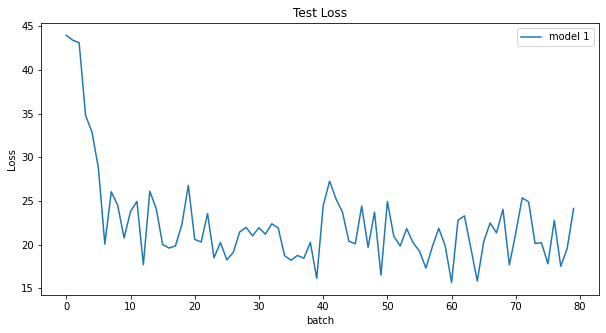


last 10 batch average RMSE = 21.370615401377286


In [19]:
##5
# test loss를 plotting 하기 위한 코드#########
plt.figure(figsize=(10,5))
plt.title("Test Loss")
plt.plot(test_loss_record, label="model 1")
plt.xlabel("batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### <RMSE 평균값 구하는 곳 > (검색용) ################################################################
### 지금은 RMSE 평균값 계산할때, RMSE 값들을 가장 마지막 "10개" 배치만을 이용하도록 되어있음
### 
### RMSE 평균값 계산할때, RMSE 값들을 가장 마지막 "n개" 배치만을 이용하도록 하고 싶으면,
### 아래 코드에서 "-10" 부분을, "-n" 으로 숫자를 바꿔주면 된다. 
#############################################################################################
last_batch_avg_RMSE = sum(test_loss_record[-10:] ,0.0) / len(test_loss_record[-10:])
print("\nlast {} batch average RMSE = {}".format(-(-10) ,last_batch_avg_RMSE))

In [20]:
# <코드 수정 기록> 
# 2021.12.05(일) pm 3
# loss 출력을 RMSE로 바꿈
# 각 배치 마다 test loss 를 리스트로 저장해서, 학습완료후에 학습진행 그래프 출력되도록 코드 추가함
# 평균 RMSE를 계산하기 위해서, 학습중 마지막 10개 배치의 RMSE의 평균값을 출력하도록 코드 추가함
# 2021.12.05(일) pm 6
# 하이퍼파라미터튜닝 할 수 있도록 중요 코드 부분 주석처리함